In [1]:
## Imports and constants
import os
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import gensim.downloader as api

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import warnings

from preprocessing import lstm_preprocessing
from zm_lstm_helper import *
from zm_lstm_model import SimpleLSTM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(20) 
np.random.seed(20)

MAX_SEQ_LEN = 200
BATCH_SIZE = 10

warnings.filterwarnings('ignore')

c:\Users\user\anaconda3\envs\web_mining_2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
raw_dataset = pd.read_csv(os.getcwd() + '\\airlines_reviews.csv')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
raw_dataset.head()

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes


In [3]:
## Preprocessing with LSTM-specific preprocessor
if False:
    tokenized_dataset = lstm_preprocessing(dataset=raw_dataset)
    tokenized_reviews = tokenized_dataset['Tokenized_Reviews']
    reviews_labels = tokenized_dataset['Sentiment']
    tokenized_dataset.head()

In [4]:
if False:
    ## Embedding / Vectorization using GloVe
        ## Note: LSTM processes the sentence sequentially, hence vectorization should be done word-by-word
    glove_model = api.load("glove-wiki-gigaword-50")


    tokenized_embedded_reviews = []
    unidentified_tokens = [] ## Tokens not in GloVe model


    for review in tokenized_reviews:
        curr_embedded_review = []
        
        for token in review:
            if token in glove_model:
                curr_embedded_review.append(glove_model[token])
            else:
                unidentified_tokens.append(token)

        tokenized_embedded_reviews.append(curr_embedded_review)


    print(f'Sample of embedded reviews:')
    print(f'Text: {tokenized_reviews[0]}')
    print(f'Vector: {tokenized_embedded_reviews[0]}')
    print(f'{len(unidentified_tokens)} total tokens not in GloVe model: \n{unidentified_tokens}')

In [5]:
## Preprocessing using common preprocessing function
processed_dataset = lstm_preprocessing(raw_dataset)
processed_dataset.head()

9643 total tokens not in GloVe model: 
['bday', 'wellmaintained', 'welltrained', 'lightingdimming', 'eyemasks', 'max8', 'problemsolving', 'flight—', 'narrowbodied', '1130am', '0830am', 'sq226896', 'lhrsinlhr', 'sinmnlsin', 'lhrsin', 'sentoff', 'empathised', 'sq217', 'au200', 'reasonwhy', '740am', '720am', '930am', 'krisflyer', 'phuketsingapore', 'allerretour', 'phuketsingapore', 'exemplaire', 'ponctualité', 'laccueil', 'boissons', 'offerts', 'souhaitant', 'effectuer', 'réservation', 'lavais', 'précédemment', 'dizaine', 'dappels', 'directement', 'singapour', 'visiblement', 'déviés', 'dautres', 'dappel', 'employés', 'suivent', 'protocole', 'tentatives', 'réservation', 'déficient', 'employés', 'sympathique', 'limités', 'réservation', 'datteindre', 'véritable', 'honte', 'chère', 'prétend', 'meilleures', 'sq101', 'sq101', 'sq127', '7378', '737800ng', 'exmi', '605pm', '950pm', 'sq285', '221123', 'punitha', 'punitha', 'punitha', 'covid', 'oneway', 'wellrespected', 'theiryour', 'clientcustomer

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Sentiment,Tokenized_Reviews,Tokenized_Embedded_Reviews
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes,2,"[flight, was, amazing, the, crew, onboard, thi...","[[1.7306, 0.284, -0.040613, -0.087372, -0.4819..."
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no,0,"[booking, an, emergency, exit, seat, still, me...","[[0.75874, -0.22013, -0.12103, 0.021208, -0.65..."
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes,2,"[excellent, performance, on, all, fronts, i, w...","[[-0.40431, 0.78002, -0.67538, -0.097149, 0.54..."
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes,2,"[pretty, comfortable, flight, considering, i, ...","[[-0.24922, -0.39835, -0.45851, -0.34846, 0.74..."
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes,2,"[the, service, was, consistently, good, from, ...","[[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -..."


In [6]:
## Using Dataset wrapper
tokenized_embedded_reviews = processed_dataset['Tokenized_Embedded_Reviews']
reviews_labels = processed_dataset['Sentiment']
reviews_dataset = ReviewsDataset(reviews=tokenized_embedded_reviews, labels=reviews_labels)
print(f'First review: {reviews_dataset[0][0]}, \nCorresponding label: {reviews_dataset[0][1]}')

First review: [array([ 1.7306   ,  0.284    , -0.040613 , -0.087372 , -0.4819   ,
       -0.4278   , -0.65733  ,  0.31632  ,  1.0554   , -0.70909  ,
        0.57747  ,  0.3628   , -0.46717  ,  0.97844  ,  0.12695  ,
       -0.39876  , -1.6432   ,  0.34616  , -1.9699   , -0.40326  ,
        0.27543  ,  0.7005   , -0.24267  , -0.0042508,  0.34004  ,
       -1.6021   ,  0.06427  ,  0.035409 ,  0.33291  ,  0.25677  ,
        2.2611   ,  0.95595  , -0.55761  , -0.12359  ,  0.74087  ,
       -0.47427  ,  0.89383  , -0.022107 , -0.38237  ,  0.87486  ,
       -0.13263  ,  0.069306 ,  1.1166   ,  0.44355  , -0.84921  ,
        0.039591 ,  0.34486  ,  0.34012  , -0.097281 ,  0.28005  ],
      dtype=float32), array([ 0.086888, -0.19416 , -0.24267 , -0.33391 ,  0.56731 ,  0.39783 ,
       -0.97809 ,  0.03159 , -0.61469 , -0.31406 ,  0.56145 ,  0.12886 ,
       -0.84193 , -0.46992 ,  0.47097 ,  0.023012, -0.59609 ,  0.22291 ,
       -1.1614  ,  0.3865  ,  0.067412,  0.44883 ,  0.17394 , -0.53574 ,


In [7]:
## Split dataset
train_set, val_set, test_set = torch.utils.data.random_split(
    reviews_dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(20)
)

In [8]:
## Create DataLoaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=review_collate_fn)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=review_collate_fn)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=review_collate_fn)

In [9]:
## Check batches
example_features, example_label = next(iter(train_loader))
print(f'Sample feature: \n{example_features}, \nFeature size: {example_features.shape}')
print(f'Sample label: \n{example_label}')

## Assert that feature size is (batch_size, sequence_length ie review_length, feature_size ie word_vec_size)
assert example_features.shape == torch.Size([10, 200, 50]), 'Batch provided by DataLoader is of wrong size'

Sample feature: 
tensor([[[ 1.9511e-01,  5.0739e-01,  1.4709e-03,  ...,  3.0488e-02,
          -1.4272e-01,  4.5411e-01],
         [-3.1828e-01,  7.8772e-01, -2.6618e-01,  ..., -3.6023e-01,
          -1.7866e-01,  1.1236e+00],
         [ 6.8047e-01, -3.9263e-02,  3.0186e-01,  ..., -7.3297e-02,
          -6.4699e-02, -2.6044e-01],
         ...,
         [-2.9116e-01,  1.1764e+00, -2.0424e-01,  ..., -5.8471e-01,
           6.4289e-01,  1.5782e-01],
         [-3.7915e-01,  6.1848e-01,  9.5930e-01,  ..., -6.2515e-01,
           5.3323e-02,  6.2023e-01],
         [-4.7572e-01, -1.5230e-01,  7.8962e-01,  ...,  1.5575e-01,
           4.0785e-01, -3.7880e-01]],

        [[ 5.3074e-01,  4.0117e-01, -4.0785e-01,  ...,  2.8762e-01,
           1.4440e-01,  2.3611e-01],
         [ 8.6888e-02, -1.9416e-01, -2.4267e-01,  ..., -7.7000e-01,
           3.9450e-01, -1.6937e-01],
         [ 2.1705e-01,  4.6515e-01, -4.6757e-01,  ..., -4.3782e-02,
           4.1013e-01,  1.7960e-01],
         ...,
        

In [10]:
## Initialize an LSTM model
    ## Hyperparameters
embedding_dim = 50
hidden_dim = 64
num_lstm_layers = 1
cell_dropout = 0.1

model = SimpleLSTM(embedding_dim, hidden_dim, num_lstm_layers, cell_dropout)
print(model)

SimpleLSTM(
  (model): ModuleDict(
    (lstm): LSTM(50, 64, batch_first=True, dropout=0.1)
    (linear1): Linear(in_features=64, out_features=3, bias=True)
    (sigmoid): Sigmoid()
  )
)


In [11]:
## Test forward pass
example_output = model(example_features.to(DEVICE))
print(f'Sample output: \n{example_output}')

Sample output: 
(tensor([[0.5033, 0.5210, 0.5110],
        [0.4997, 0.5243, 0.5028],
        [0.4934, 0.5229, 0.4791],
        [0.4906, 0.5268, 0.4738],
        [0.4997, 0.5243, 0.5028],
        [0.4997, 0.5243, 0.5028],
        [0.4997, 0.5243, 0.5028],
        [0.4997, 0.5243, 0.5028],
        [0.4942, 0.5274, 0.4710],
        [0.4976, 0.5165, 0.4660]], grad_fn=<SigmoidBackward0>), tensor([[-0.2206, -0.0393, -0.1002,  0.0566,  0.1983,  0.0895,  0.1159, -0.0149,
          0.0316, -0.1065,  0.1008, -0.2172,  0.0235,  0.0799, -0.2020, -0.0945,
          0.0616,  0.0665, -0.1143,  0.0052, -0.0643,  0.1450,  0.1935,  0.0061,
         -0.1113,  0.0522,  0.0423, -0.0689,  0.0801, -0.1493,  0.3180,  0.1288,
         -0.0328, -0.1161, -0.0347,  0.1733, -0.1627,  0.0766,  0.0922, -0.0086,
         -0.2625,  0.0103, -0.0620,  0.1305,  0.0235,  0.1631,  0.0568, -0.1363,
          0.1307,  0.0182,  0.0603,  0.0915,  0.0360,  0.0262,  0.0053,  0.1821,
         -0.0913,  0.0254, -0.1552, -0.0584,  

In [ ]:
## Test evaluation function
example_loss, example_f1 = evaluation(model, val_loader)
print(f'Loss: {example_loss}')
print(f'F1: {example_f1}')

In [ ]:
## Training the model
embedding_dim = 50
hidden_dim = 64
num_lstm_layers = 2
cell_dropout = 0.1

model = SimpleLSTM(embedding_dim, hidden_dim, num_lstm_layers, cell_dropout)

trained_model = train_model(model, train_loader, val_loader, lr=0.001, epochs=2)

## Save model
curr_datetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
file_dir = '.experiments/'
file_name = f'model_{curr_datetime}.pt'
torch.save(model.state_dict(), file_dir + file_name)

In [ ]:
## Hyperparameter tuning
    ## Embedding (size, method)
    ## Hidden dimension
    ## LSTM layers
    ## Bidirectional
    ## Dropout probability
    ## Learning rate

In [ ]:
## Hyperparameter tuning
param_grid = {
    'hidden_dim': [32, 64],
    'lstm_layers': [2, 3],
    'dropout': [0.1, 0.8]
}
embedding_dim = 50

models = []

for curr_hidden_dim in param_grid['hidden_dim']:
    for curr_num_lstm_layers in param_grid['lstm_layers']:
        for curr_dropout in param_grid['dropout']:
            text = f'hidden_dim: {curr_hidden_dim}, num_lstm_layers: {curr_num_lstm_layers}, dropout: {curr_dropout}'
            print(text)

            curr_model = SimpleLSTM(embedding_dim, curr_hidden_dim, curr_num_lstm_layers, curr_dropout)
            curr_trained_model = train_model(curr_model, train_loader, val_loader, lr=0.001, epochs=10)
            models.append((text, curr_trained_model))
    

Best hyperparameter values  
Hidden layer size: ??  
LSTM layers: ??  
Dropout probability: ??  

In [ ]:
## Train model again with best hyperparameters
embedding_dim = 50
hidden_dim = 64
num_lstm_layers = 2
cell_dropout = 0.8

best_model = SimpleLSTM(embedding_dim, hidden_dim, num_lstm_layers, cell_dropout)

## Initialize early stopper
curr_datetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
file_dir = '.experiments/tuned/'
file_name = f'model_{curr_datetime}.pt'

early_stopper = EarlyStopper(patience=3, delta=0.005, path=file_dir+file_name)

## Train model, stopping when no further improvements
best_model = train_model(best_model, train_loader, val_loader, lr=0.001, epochs=100, early_stopper=early_stopper)

Load and evaluate trained model on test set

In [11]:
## Evaluate model performance on test set
best_model = SimpleLSTM(embedding_dim=50, hidden_dim=64, num_lstm_layers=2, cell_dropout=0.1).to(DEVICE)
best_model.load_state_dict(torch.load('.experiments\lstm_trained_model.pt'))

test_loss, test_f1 = evaluation(best_model, test_loader)
print(f'Test loss: {test_loss / len(test_loader):.4f}\t', f'Test F1: {test_f1}')

Test loss: 0.6474	 Test F1: 0.89228881914778


In [12]:
## Retrieving the performance scores for each class
all_pred_class = []
all_labels = []

for reviews, labels in test_loader:
    reviews, labels = reviews.to(DEVICE), labels.to(DEVICE)

    ## Forward pass
    pred, thought_vector = best_model(reviews)
    pred_class = torch.argmax(pred, dim=1).to('cpu')

    all_pred_class.extend(pred_class.numpy())
    all_labels.extend(labels.to('cpu').numpy())

assert len(all_pred_class) == len(all_labels)

F1 scores:
{0: 0.9187592319054653, 1: 0.4489795918367347, 2: 0.9443786982248521}
Confusion matrix
[[311   8  13]
 [ 23  22  23]
 [ 11   0 399]]


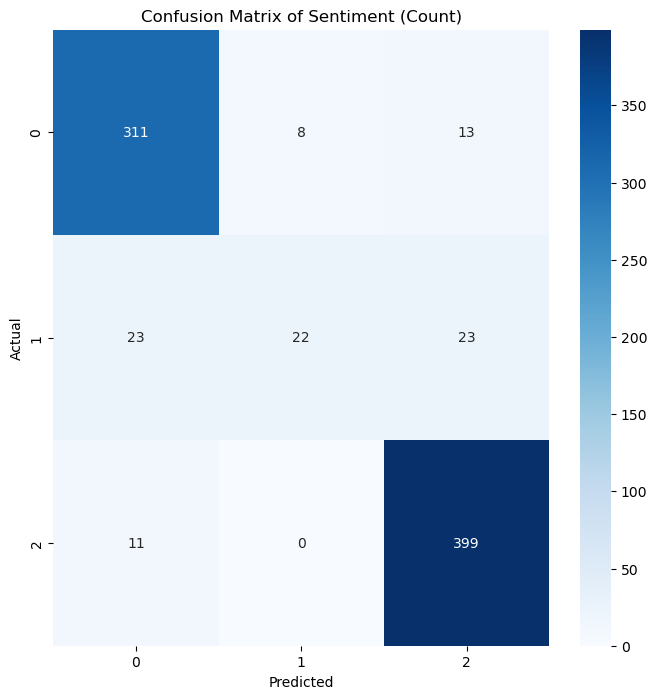

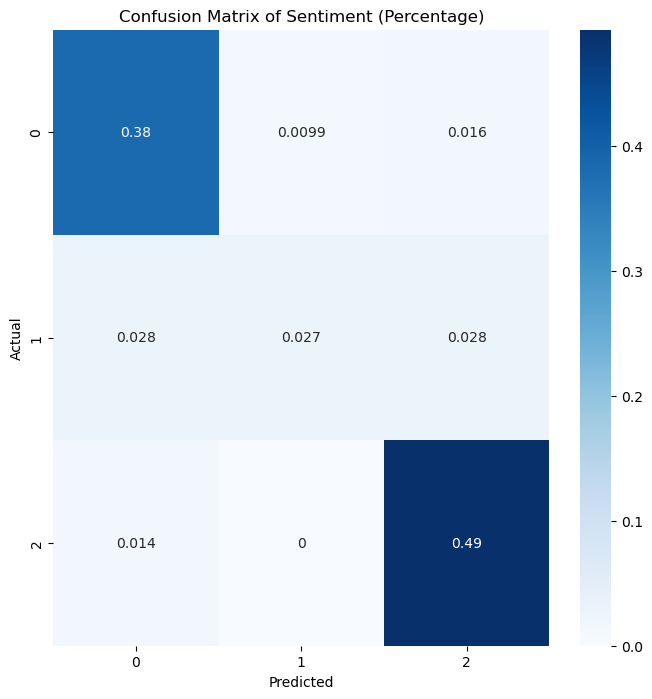

In [13]:
## Calculate F1 scores and generate confusion matrix
all_labels = [int(x) for x in all_labels]
all_pred_class = [int(x) for x in all_pred_class]
f1_scores_dict = scoring(all_labels, all_pred_class, labels=[0,1,2])
cm = confusion_matrix(all_labels, all_pred_class)

print('F1 scores:')
print(f1_scores_dict)

print('Confusion matrix')
print(cm)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Sentiment (Count)')
plt.show()   

plt.figure(figsize=(8, 8))
sns.heatmap(cm / np.sum(cm), annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Sentiment (Percentage)')
plt.show()

Error analysis  
  
Unfortunately, the current implementation makes it difficult to directly identify misclassifications on the test set. Hence we will sample some neutral classes from the dataset and assess the model's performance on them

In [12]:
## Error analysis


In [42]:
## Sample some neutral reviews
sampled_rows = processed_dataset[processed_dataset['Sentiment'] == 1].sample(n=10, random_state=20)
sampled_rows.head()

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Sentiment,Tokenized_Reviews,Tokenized_Embedded_Reviews
1932,changed terminal in Singapore,Michael Schade,2019-03-18,Qatar Airways,True,Oslo to Singapore via Doha. Top notch flight...,Business,February 2019,Bangkok to Washington DC via Doha,Business Class,4,4,4,5,4,5,yes,1,"[oslo, to, singapore, via, doha, top, notch, f...","[[0.055764, 1.206, -0.59057, -0.50866, -0.1058..."
122,Impeccable service,Roberto Giusto,2023-04-01,Singapore Airlines,False,"Impeccable service, just be aware of the tim...",Couple Leisure,March 2023,Milan to Manila via Singapore,Economy Class,4,4,2,4,3,5,no,1,"[impeccable, service, just, be, aware, of, the...","[[-1.0681, -0.014629, -1.404, -0.18676, 0.4397..."
7059,A bit disappointed,F Carter,2019-10-26,Cathay Pacific Airways,True,Melbourne to Hong Kong. A bit disappointed c...,Business,October 2019,Melbourne to Hong Kong,Economy Class,1,5,4,5,4,5,no,1,"[melbourne, to, hong, kong, a, bit, disappoint...","[[-0.64534, 0.60394, -0.72158, 0.32312, -0.925..."
4248,sit together in the middle row,Vidya Tapasanan,2022-06-08,Japan Airlines,True,My wife and I flied JAL economy class back f...,Couple Leisure,June 2022,Tokyo Haneda to Bangkok,Economy Class,1,4,5,5,3,6,no,1,"[my, wife, and, i, flied, jal, economy, class,...","[[-0.27279, 0.77515, -0.10181, -0.9166, 0.9047..."
4113,avoid flying Emirates Boeing 777-300,M Fiaz,2016-09-01,Emirates,True,Manchester to Tokyo Narita via Dubai. First ...,Business,August 2016,MEL to KUL,Economy Class,5,3,5,5,2,5,no,1,"[manchester, to, tokyo, narita, via, dubai, fi...","[[-0.034062, 0.65314, -0.51061, -0.42282, -0.3..."


In [43]:
## Perform forward pass on sampled reviews
best_model = SimpleLSTM(embedding_dim=50, hidden_dim=64, num_lstm_layers=2, cell_dropout=0.1).to(DEVICE)
best_model.load_state_dict(torch.load('.experiments\lstm_trained_model.pt'))

y_pred, _ = best_model(torch.Tensor([pad_review(x, 50) for x in sampled_rows['Tokenized_Embedded_Reviews']]))
pred_class = torch.argmax(y_pred, dim=1).to('cpu')

In [49]:
## Inspect results
sampled_rows_2 = sampled_rows.reset_index(inplace=False)
error_analysis_df = pd.DataFrame(
    data={
        'Data index': sampled_rows_2['index'],
        'Review text': sampled_rows_2['Reviews'],
        'True sentiment': sampled_rows_2['Sentiment'],
        'Prediction': pred_class.numpy()
    }  
)
pd.set_option('display.max_colwidth', None)
display(error_analysis_df)

# sampled_rows_2 = sampled_rows.reset_index(inplace=False)
# for idx in range(len(sampled_rows)):
#     print(f'Review {sampled_rows_2["index"][idx]}: \n{sampled_rows_2["Reviews"][idx]}')
#     print(f'True sentiment: {sampled_rows_2["Sentiment"][idx]}. Predicted: {pred_class[idx]} \n')

,Data index,Review text,True sentiment,Prediction
0,1932,"Oslo to Singapore via Doha. Top notch flights, all on the A350. Oslo Doha sector on the 359, using the herringbone configuration, and Oslo Singapore the A350-1000 Qsuite. Seats and service as usual top notch. These flights at Doha were at remote locations using busses which is inconvinient and time consuming, with departures using the bus gates totally unorganized. Qatar changed the departure terminal in Singapore from T3 to T1. This is a big downgrade. T1 is mainly for budget carrier and the lounge was so crowded with just basic F&B. Qatar should be more consistent with its product.",1,0
1,122,"Impeccable service, just be aware of the timing of connections, they sell tickets with only one hour stopover. Do not accept to buy connecting flights with less than 2 hour time stopover.",1,2
2,7059,"Melbourne to Hong Kong. A bit disappointed considering that Cathay is a 5 star airline. I know that this trip was in economy and I did not expect business class However, no water was brought to us during the long flight and the entertainment system was not working well. I used the call button but nobody showed up. Cathay is good in business class but not in economy class.",1,1
3,4248,"My wife and I flied JAL economy class back from Japan to Thailand early this month. The check-in was very good, The staff were very nice and efficient. We have made prior window seat booking to sit together, however, we were informed that JAl change the type of plane from B77 to B787 which is smaller, So we were not assigned to sit together by the window. Instead they assigned us to sit together in the middle row of 2-4-2 which means that we had other passengers on both side which made us very uncomfortable throughout the flight. The service is good, the food is OK.",1,2
4,4113,"Manchester to Tokyo Narita via Dubai. First leg from Manchester to Dubai was very good in A380 with good legroom and excellent inflight cabin service. However, WiFi did not work. Boeing 777-300 from Dubai to Narita was very cramped. Emirates have taken off 1 inch from each seat to squeeze additional one seat in a 3-4-3 configuration. This makes the seating very uncomfortable. ICE system did not work very well. Return journey from Osaka to Dubai was also bad. Boeing 777-300 cabin had a dated look. Seating very uncomfortable. My seat did not recline. Passenger sitting next to me had to move as that seat would not recline either. Toilets were dirty and had no water in the basin to wash hands. Cabin crew very slow in serving any foods/drinks. It took over three hours before any drinks or food was served after departure. Headphones did not work properly. Had to try 3 different headphones before I found one that worked. Airbus A380 from Dubai to Manchester was fine. I will avoid flying on Emirates Boeing 777-300 to Japan in future.",1,2
5,7244,"In August 2018, I flew Cathay Pacific from Vancouver to Johannesburg via Hong Kong in Economy Class My return trip used the same route but on Premium Economy. Departure time was delayed, food was average, perhaps because I ordered a special meal (Moslem meal). On both outbound and inbound trips, I was served food with lack of politeness. I had the impression that I was being sort of punished for ordering a special meal: I was once denied bread, my claim for coffee many times ignored. However, I refrained from complaining. Seats were fair on Economy and very good on Premium Economy. No particular complaint over seats. Inflight entertainment was excellent. Being a Marco Polo Green member didn’t really give me the kind of treatment I was expecting. Above all I was struck by the rudeness of stewardess I dealt with on both outbound and inbound flights.",1,1
6,7679,Eva Air's slogan 'Striving for Perfection' is a strong strap line yet standards have fallen since Covid. I have used Eva on the London to Bangkok route since they started flying from Gatwick in 1994. Unfortunately my first post Covid fli